In [1]:
import pandas as pd
df = pd.read_csv('miami_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:57:17.644000,VER,1,0 days 00:01:34.338000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:34.990000,...,True,Red Bull Racing,0 days 00:55:43.028000,2024-05-05 20:03:23.796,1,1.0,False,NaN,False,False
1,0 days 00:58:50.737000,VER,1,0 days 00:01:33.093000,2.0,1.0,NaN,NaN,0 days 00:00:31.455000,0 days 00:00:35.489000,...,True,Red Bull Racing,0 days 00:57:17.644000,2024-05-05 20:04:58.412,1,1.0,False,NaN,False,True
2,0 days 01:00:23.874000,VER,1,0 days 00:01:33.137000,3.0,1.0,NaN,NaN,0 days 00:00:31.551000,0 days 00:00:35.472000,...,True,Red Bull Racing,0 days 00:58:50.737000,2024-05-05 20:06:31.505,1,1.0,False,NaN,False,True
3,0 days 01:01:57.378000,VER,1,0 days 00:01:33.504000,4.0,1.0,NaN,NaN,0 days 00:00:31.508000,0 days 00:00:35.686000,...,True,Red Bull Racing,0 days 01:00:23.874000,2024-05-05 20:08:04.642,1,1.0,False,NaN,False,True
4,0 days 01:03:30.212000,VER,1,0 days 00:01:32.834000,5.0,1.0,NaN,NaN,0 days 00:00:31.318000,0 days 00:00:35.410000,...,True,Red Bull Racing,0 days 01:01:57.378000,2024-05-05 20:09:38.146,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0 days 02:21:15.138000,PIA,81,0 days 00:01:32.610000,53.0,3.0,NaN,NaN,0 days 00:00:31.675000,0 days 00:00:35.281000,...,False,McLaren,0 days 02:19:42.528000,2024-05-05 21:27:23.296,1,16.0,False,NaN,False,True
1107,0 days 02:22:47.070000,PIA,81,0 days 00:01:31.932000,54.0,3.0,NaN,NaN,0 days 00:00:31.311000,0 days 00:00:35.210000,...,False,McLaren,0 days 02:21:15.138000,2024-05-05 21:28:55.906,1,15.0,False,NaN,False,True
1108,0 days 02:24:18.735000,PIA,81,0 days 00:01:31.665000,55.0,3.0,NaN,NaN,0 days 00:00:30.878000,0 days 00:00:35.143000,...,False,McLaren,0 days 02:22:47.070000,2024-05-05 21:30:27.838,1,15.0,False,NaN,False,True
1109,0 days 02:25:50.789000,PIA,81,0 days 00:01:32.054000,56.0,3.0,NaN,NaN,0 days 00:00:31.051000,0 days 00:00:35.296000,...,False,McLaren,0 days 02:24:18.735000,2024-05-05 21:31:59.503,1,15.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 57  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              2              11.0               19.0   
1    ALO              1              23.0               28.5   
2    BOT              2              12.0               19.0   
3    GAS              1              13.0               28.5   
4    HAM              1              27.0               28.5   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          0.070175          0.175439         0.754386  
1          0.000000          0.614035         0.385965  
2          0.192982          0.491228         0.315789  
3          0.000000          0.210526         0.789474  
4          0.000000          0.543860         0.456140  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,10.0,0 days 01:11:35.822000,NaN,MEDIUM,10.0,1.0
1,ALB,11.0,NaN,0 days 01:11:58.502000,HARD,1.0,2.0
2,ALB,53.0,0 days 02:21:22.882000,NaN,HARD,43.0,2.0
3,ALB,54.0,NaN,0 days 02:21:45.328000,SOFT,1.0,3.0
4,ALO,22.0,0 days 01:30:31.237000,NaN,HARD,23.0,1.0
5,ALO,23.0,NaN,0 days 01:30:53.595000,MEDIUM,2.0,2.0
6,BOT,11.0,0 days 01:13:14.893000,NaN,SOFT,11.0,1.0
7,BOT,12.0,NaN,0 days 01:13:38.589000,HARD,1.0,2.0
8,BOT,29.0,0 days 01:42:54.063000,NaN,HARD,18.0,2.0
9,BOT,30.0,NaN,0 days 01:43:16.848000,MEDIUM,1.0,3.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,11.0,19.00,0.070175,0.175439,0.754386
1,ALO,1,23.0,28.50,0.000000,0.614035,0.385965
2,BOT,2,12.0,19.00,0.192982,0.491228,0.315789
3,GAS,1,13.0,28.50,0.000000,0.210526,0.789474
4,HAM,1,27.0,28.50,0.000000,0.543860,0.456140
5,HUL,2,13.0,19.00,0.000000,0.719298,0.280702
6,LEC,1,20.0,28.50,0.000000,0.333333,0.666667
7,MAG,3,23.0,14.25,0.000000,0.614035,0.385965
8,NOR,1,30.0,28.50,0.000000,0.508772,0.491228
9,OCO,1,23.0,28.50,0.000000,0.385965,0.614035


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,934


In [9]:
df['Driver'].value_counts()


,count
Driver,
NOR,50
VER,49
MAG,49
ALO,49
SAI,49
OCO,49
ZHO,49
TSU,49
RIC,49


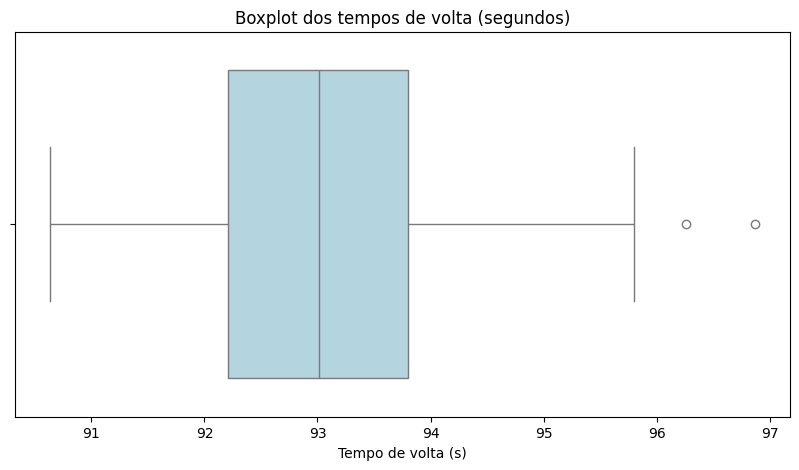

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


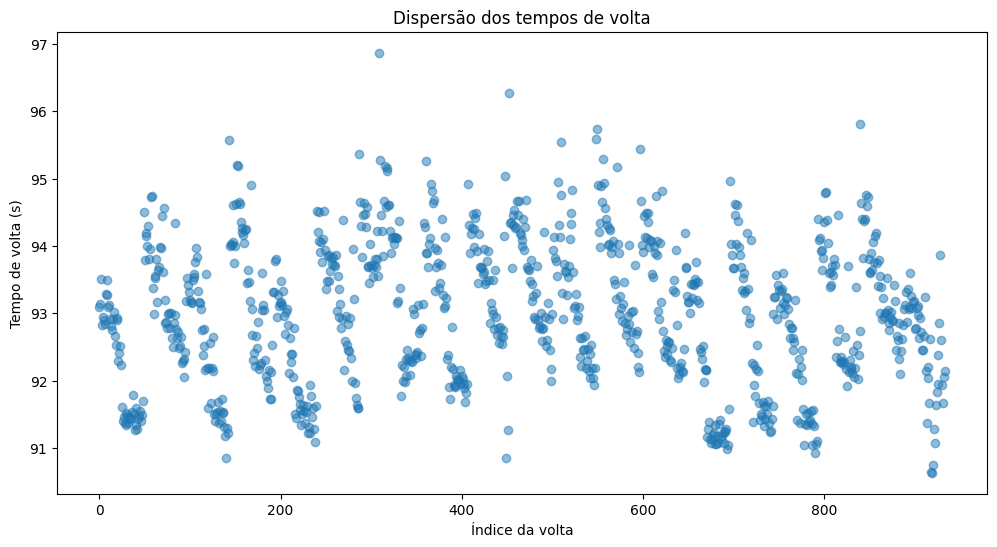

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


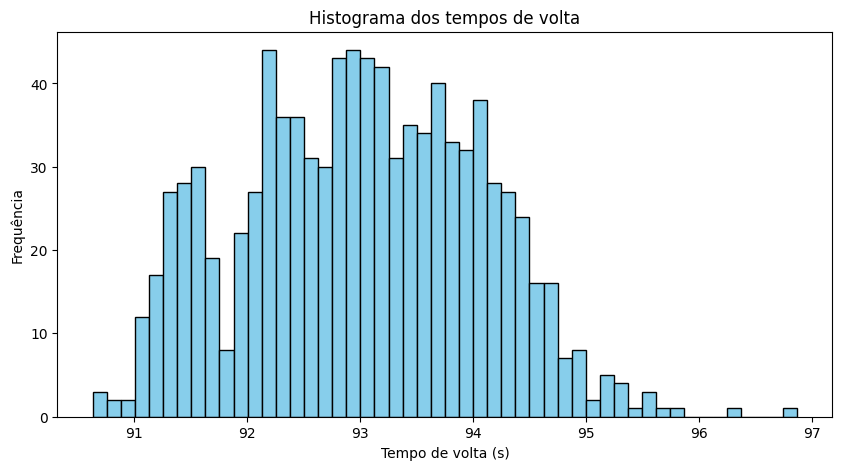

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


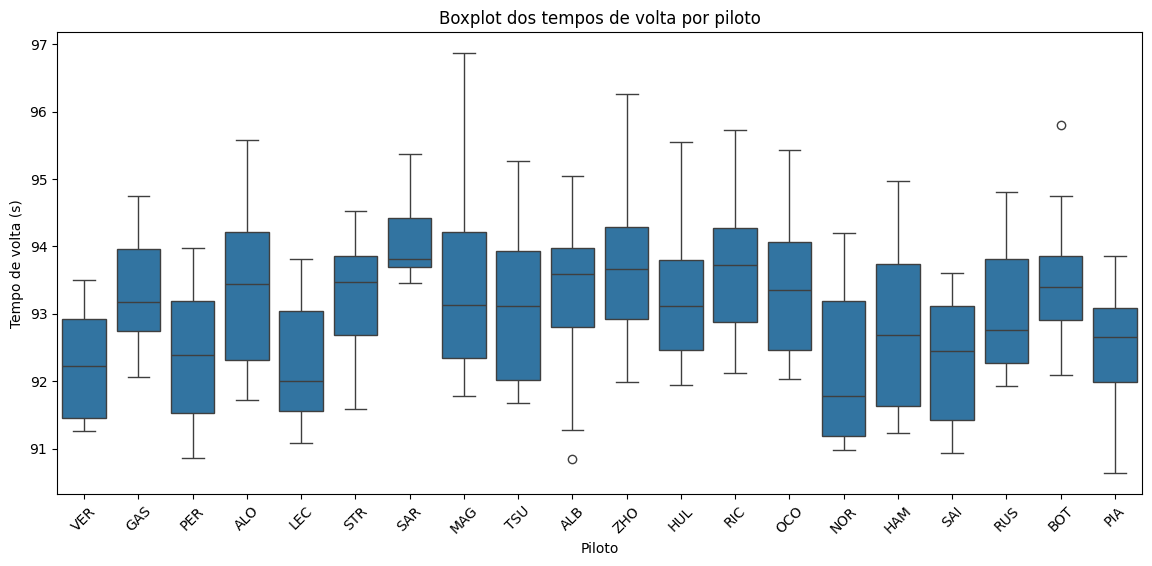

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
PIA   0 days 00:01:30.634000
ALB   0 days 00:01:30.849000
PER   0 days 00:01:30.855000
SAI   0 days 00:01:30.928000
NOR   0 days 00:01:30.980000
LEC   0 days 00:01:31.084000
HAM   0 days 00:01:31.233000
VER   0 days 00:01:31.261000
STR   0 days 00:01:31.588000
TSU   0 days 00:01:31.682000
ALO   0 days 00:01:31.727000
MAG   0 days 00:01:31.774000
RUS   0 days 00:01:31.921000
HUL   0 days 00:01:31.941000
ZHO   0 days 00:01:31.991000
OCO   0 days 00:01:32.037000
GAS   0 days 00:01:32.055000
BOT   0 days 00:01:32.098000
RIC   0 days 00:01:32.122000
SAR   0 days 00:01:33.452000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Miami'
race_date = '2024-05-05'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,45,93.438689,0.861210,90.849,95.038,93.5840,4.189,2024,Miami,2024-05-05
1,ALO,49,93.371184,1.054816,91.727,95.579,93.4470,3.852,2024,Miami,2024-05-05
2,BOT,47,93.465128,0.769853,92.098,95.803,93.4000,3.705,2024,Miami,2024-05-05
3,GAS,47,93.328106,0.750559,92.055,94.743,93.1740,2.688,2024,Miami,2024-05-05
4,HAM,48,92.744396,1.170080,91.233,94.966,92.6910,3.733,2024,Miami,2024-05-05
5,HUL,47,93.239660,0.904720,91.941,95.543,93.1150,3.602,2024,Miami,2024-05-05
6,LEC,48,92.244792,0.809213,91.084,93.809,91.9965,2.725,2024,Miami,2024-05-05
7,MAG,49,93.393265,1.158240,91.774,96.868,93.1340,5.094,2024,Miami,2024-05-05
8,NOR,50,92.129840,1.032473,90.980,94.199,91.7785,3.219,2024,Miami,2024-05-05
9,OCO,49,93.339408,0.921172,92.037,95.438,93.3480,3.401,2024,Miami,2024-05-05


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,45,93.438689,0.861210,90.849,95.038,93.5840,4.189,2024,Miami,2024-05-05,57.0,True
1,ALO,49,93.371184,1.054816,91.727,95.579,93.4470,3.852,2024,Miami,2024-05-05,57.0,True
2,BOT,47,93.465128,0.769853,92.098,95.803,93.4000,3.705,2024,Miami,2024-05-05,57.0,True
3,GAS,47,93.328106,0.750559,92.055,94.743,93.1740,2.688,2024,Miami,2024-05-05,57.0,True
4,HAM,48,92.744396,1.170080,91.233,94.966,92.6910,3.733,2024,Miami,2024-05-05,57.0,True
5,HUL,47,93.239660,0.904720,91.941,95.543,93.1150,3.602,2024,Miami,2024-05-05,57.0,True
6,LEC,48,92.244792,0.809213,91.084,93.809,91.9965,2.725,2024,Miami,2024-05-05,57.0,True
7,MAG,49,93.393265,1.158240,91.774,96.868,93.1340,5.094,2024,Miami,2024-05-05,57.0,True
8,NOR,50,92.129840,1.032473,90.980,94.199,91.7785,3.219,2024,Miami,2024-05-05,57.0,True
9,OCO,49,93.339408,0.921172,92.037,95.438,93.3480,3.401,2024,Miami,2024-05-05,57.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,11.0,19.00,0.070175,0.175439,0.754386
1,ALO,1,23.0,28.50,0.000000,0.614035,0.385965
2,BOT,2,12.0,19.00,0.192982,0.491228,0.315789
3,GAS,1,13.0,28.50,0.000000,0.210526,0.789474
4,HAM,1,27.0,28.50,0.000000,0.543860,0.456140
5,HUL,2,13.0,19.00,0.000000,0.719298,0.280702
6,LEC,1,20.0,28.50,0.000000,0.333333,0.666667
7,MAG,3,23.0,14.25,0.000000,0.614035,0.385965
8,NOR,1,30.0,28.50,0.000000,0.508772,0.491228
9,OCO,1,23.0,28.50,0.000000,0.385965,0.614035


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,45,93.438689,0.861210,90.849,95.038,93.5840,4.189,2024,Miami,2024-05-05,57.0,True,2,11.0,19.00,0.070175,0.175439,0.754386
1,ALO,49,93.371184,1.054816,91.727,95.579,93.4470,3.852,2024,Miami,2024-05-05,57.0,True,1,23.0,28.50,0.000000,0.614035,0.385965
2,BOT,47,93.465128,0.769853,92.098,95.803,93.4000,3.705,2024,Miami,2024-05-05,57.0,True,2,12.0,19.00,0.192982,0.491228,0.315789
3,GAS,47,93.328106,0.750559,92.055,94.743,93.1740,2.688,2024,Miami,2024-05-05,57.0,True,1,13.0,28.50,0.000000,0.210526,0.789474
4,HAM,48,92.744396,1.170080,91.233,94.966,92.6910,3.733,2024,Miami,2024-05-05,57.0,True,1,27.0,28.50,0.000000,0.543860,0.456140
5,HUL,47,93.239660,0.904720,91.941,95.543,93.1150,3.602,2024,Miami,2024-05-05,57.0,True,2,13.0,19.00,0.000000,0.719298,0.280702
6,LEC,48,92.244792,0.809213,91.084,93.809,91.9965,2.725,2024,Miami,2024-05-05,57.0,True,1,20.0,28.50,0.000000,0.333333,0.666667
7,MAG,49,93.393265,1.158240,91.774,96.868,93.1340,5.094,2024,Miami,2024-05-05,57.0,True,3,23.0,14.25,0.000000,0.614035,0.385965
8,NOR,50,92.129840,1.032473,90.980,94.199,91.7785,3.219,2024,Miami,2024-05-05,57.0,True,1,30.0,28.50,0.000000,0.508772,0.491228
9,OCO,49,93.339408,0.921172,92.037,95.438,93.3480,3.401,2024,Miami,2024-05-05,57.0,True,1,23.0,28.50,0.000000,0.385965,0.614035


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoMiami.csv', index=False)
